## Importando as bibliotecas utilizadas

In [1]:
import cv2
#import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.image as mpimg
#from scipy.spatial import distance as dist
from imutils.perspective import four_point_transform
from imutils import contours
import imutils

##Lembrar de verificar quais libs nao estao sendo utilizada

## Função auxiliar para printar a imagem na tela

In [2]:
def show_image(image):
    plt.figure()
    plt.imshow(image)

## Transformando a imagem de exemplo em preto e branco (ou nesse caso, amarelo e roxo) e fazendo as devidas transformações morfológicas

### Essa função foi testada e reescrita diversas vezes passando diferentes tipos de valores e transformações morfológicas, por conta disso, criei uma "função final" dela, que contém vários parâmetros opcionais que dita quais operações serão feitas

In [66]:
#Por padrao, nao inverte a cor
def limpa_imagem_oper_morfol(image, kernel_values,inv_cor=False,opn=False,close=False,dilat=False,eros=False):
    #image = cv2.imread(caminho_imagem)
    #Transformando a imagem em escala de cinza
    gray_scale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    #Inverter a cor, se necessario
    if(inv_cor):
        gray_scale_image = cv2.bitwise_not(gray_scale_image)
        
    #Revelando regioes mais escuras (ou seja, os digitos) do que a regiao claras (o fundo)
    thresh = cv2.threshold(gray_scale_image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    #Limpando a imagem com operações morfologicas (Abertura e fechamento)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_values)
    
    #Consultado em:
    #https://bityli.com/z6LQnF (Link encurtado -> Transformacoes morfologicas)
    if(opn):
        thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    if(close):
        thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    if(eros):
        thresh = cv2.erode(thresh, kernel)
    if(dilat):
        thresh = cv2.dilate(thresh, kernel)
    

    return thresh

## Com os filtros aplicados a imagem, vamos trabalhar em cima dela.

### Primeiro, aplicamos o filtro de contorno, em seguida, armazenamos o contorno dos digitos.

### Retorna uma imagem com os contornos dos possiveis dígitos e uma lista dos contornos dos dígitos

### Mesmo com a alteração dessa função e da próxima (classifica_digitos), a execução da primeira base de testes SEM melhorias não sofre alterações no resultado, ou seja, os valores de max_width, max_height e verificação do número '1', não influenciam nos resultados (que já seriam errados).

### As alterações influenciam nos testes seguintes, onde de fato é pedido para fazer ajustes e melhorias, nas quais os testes saem com melhores resultados.

In [26]:
#Os valores padroes de max_width e max_height nao influenciam nos testes SEM melhorias
def encontra_digitos_image(imagem_transform_morfo, width=10, height=3, max_width=1000, max_height=1000):
#def encontra_digitos_image(imagem_transform_morfo, width, height):
    for_show_img_contor = imagem_transform_morfo.copy()
    #Aplicando o filtro de contorno e encontrando-os
    cnts = cv2.findContours(imagem_transform_morfo, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    #Lista para armazenar os contornos dos digitos
    digitCnts = []

    #Loops nos candidatos da area de digitos
    for c in cnts:
        #Calcula a "caixa" de um possivel digito
        (x, y, w, h) = cv2.boundingRect(c)
        #print(x, y, w, h)
        ###ESSE IF IMPACTA MUITO NO RESULTADO!
        #if(w >= width and (h >= height)):
        #if(w >= 15 and (h >= 30 and h <= 40)):
        #if(w >= width and (h >= height and h <= max_height)):
        #if((w >= width and h >= height) and (w <= max_width and h <= max_height)):
        if((w >= width and w <= max_width) and (h >= height and h <= max_height)):
            digitCnts.append(c)
            #Ultimo valor == espessura do retangulo
            #Pintando de verde (R, G, B)
            cv2.rectangle(for_show_img_contor, (x,y), (x+w, y+h), (100, 100, 100), 1)

    #Classificando os contos da esquerda para a direita (mesma direcao em que leriamos os digitos)
    digitCnts = contours.sort_contours(digitCnts, method="left-to-right")[0]
    return for_show_img_contor, digitCnts


## Com a lista de possiveis digitos feita, vamos agora identificar quais digitos são esses
### Temos um dicionário cuja a tupla é a chave de um digito em si. 
### A chave que indentificará qual é o possível dígito, é gerada dentro do for que caminha na lista de possíveis dígitos, calculando a altura e largura extraindo os sete segmentos do dígito. Verificando se determinado segmento está ligado ou não, e com base nisso, conseguindo identificar qual dígito ele é.

In [17]:
#width e height para a verificacao do numero '1', visto que ele eh um caso especial.
def classifica_digitos(image, imagem_limpa, lista_digitos, area_estimada, width_1=0, height_1=0):
    #Dicionario cujo a chave eh uma tupla que indica qual numero ele eh
    #--O NUMERO DOIS ESTAVA COM A TUPLA ERRADA--
    DIGITS_LOOKUP = {
        (1, 1, 1, 0, 1, 1, 1): 0,
        (0, 0, 1, 0, 0, 1, 0): 1,
        (1, 0, 1, 1, 1, 0, 1): 2,
        (1, 0, 1, 1, 0, 1, 1): 3,
        (0, 1, 1, 1, 0, 1, 0): 4,
        (1, 1, 0, 1, 0, 1, 1): 5,
        (1, 1, 0, 1, 1, 1, 1): 6,
        (1, 0, 1, 0, 0, 1, 0): 7,
        (1, 1, 1, 1, 1, 1, 1): 8,
        (1, 1, 1, 1, 0, 1, 1): 9
    }
    digits = []
    #Armazenando uma copia da imagem original em output, para mostrar a saida
    output = image.copy()
    #Loop em cada um dos digitos
    for c in lista_digitos:
        #Para cada uma das regioes, calculamos a caixa delimitadora e extraimos o digito ROI
        (x, y, w, h) = cv2.boundingRect(c)
        #print(f"W:{w}, H:{h}")

        #Largura e altura aproximadas de cada segmento com base nas dimensoes do ROI
        roi = imagem_limpa[y:y + h, x:x + w]

        (roiH, roiW) = roi.shape
        (dW, dH) = (int(roiW * 0.25), int(roiH * 0.15))
        dHC = int(roiH * 0.05)

        #Lista de (x, y) coordenadas que correspondem aos sete segmentos
        segments = [
            ((0, 0), (w, dH)),                           # top
            ((0, 0), (dW, h // 2)),                      # top-left
            ((w - dW, 0), (w, h // 2)),                  # top-right
            ((0, (h // 2) - dHC) , (w, (h // 2) + dHC)), # center
            ((0, h // 2), (dW, h)),	                     # bottom-left
            ((w - dW, h // 2), (w, h)),                  # bottom-right
            ((0, h - dH), (w, h))                        # bottom
        ]

        #Lista que informa se determinado segmento esta ligado. Valor 0 == segmento desligado
        #[0, 0, 0, 0, 0, 0, 0]
        on_list = [0] * len(segments)
    
        #Caso especial para o numero 1
        if(w < width_1 and h > height_1):
            on_list = [0,0,1,0,0,1,0]
        else:
            #Loop sobre os segmentos
            for (i, ((xA, yA), (xB, yB))) in enumerate(segments):
                #Extraindo o ROI do segmento
                segROI = roi[yA:yB, xA:xB]

                #Numero de pixels do segmento q estao "ligados"
                total = cv2.countNonZero(segROI)
                area = (xB - xA) * (yB - yA)
                #Se a proporcao de pixels diferentes de 0 para a area do segmento 
                #for maior que a area recebida => O segmento estao ligado
                #area_estimada = 0.4 || 0.5 +-
                if(total / float(area)) > area_estimada:
                    on_list[i] = 1

        #IF Necessario para casos de erro
        if(tuple(on_list) in DIGITS_LOOKUP.keys()):
            digit = DIGITS_LOOKUP[tuple(on_list)]
            digits.append(digit)
        else:
            #NF == NOT FOUND
            digit = 'NF'
            digits.append('NF')

        #Desenhando uma caixa em torno do digito e exibindo qual digito ele eh
        cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 1)
        cv2.putText(output, str(digit), (x+10,y+20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    
    return output, digits

# Executando o teste base

Digitos encontrados
[3, 4, 5]


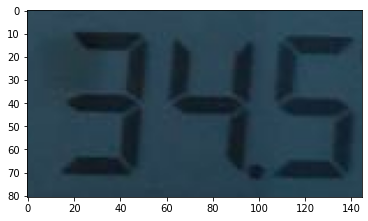

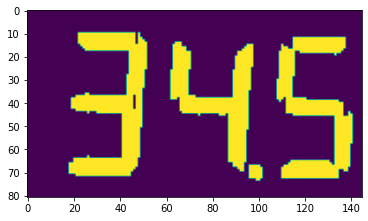

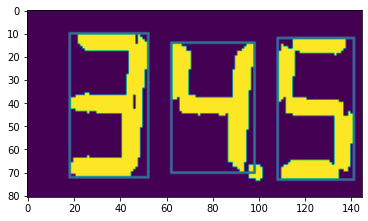

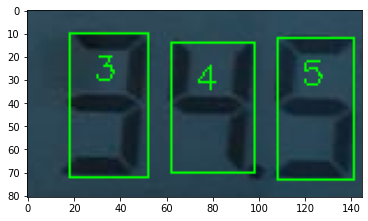

In [67]:
def exec_teste():
    imagem_exemplo = "ex.png"
    #Lendo a imagem
    img = cv2.imread(imagem_exemplo)
    show_image(img)

    #Limpando a imagem
    #Imagem / valores do kernel / operacoes desejadas
    clean_image = limpa_imagem_oper_morfol(img, (1,5), opn=True, close=True)
    show_image(clean_image)

    #Encontrando os possiveis digitos
    #imagem / largura / altura / largura_max / altura_max (Implementar?)
    #img_possiveis_digitos, possiveis_digitos = encontra_digitos_image(clean_image, 10, 3, 20, 90)
    img_possiveis_digitos, possiveis_digitos = encontra_digitos_image(clean_image, 10, 3)
    show_image(img_possiveis_digitos)
    
    #Identificando os possiveis digitos
    #imagem original / imagem limpa / lista de possiveis digitos / area estimada
    res_img, res_digits = classifica_digitos(img, clean_image, possiveis_digitos, 0.5)
    show_image(res_img)
    
    print("Digitos encontrados")
    print(res_digits)
exec_teste()

# Executando a primeira Base de testes SEM melhorias

#### Mesmo com o tratamento do número 1, ele não foi identificado nos testes

[8]
[3, 4, 5]
[8]


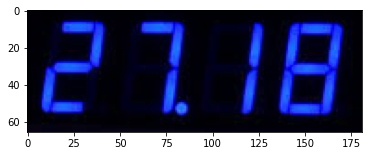

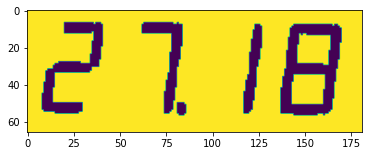

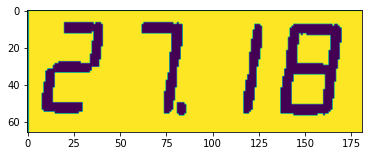

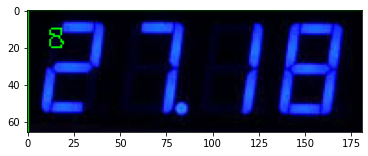

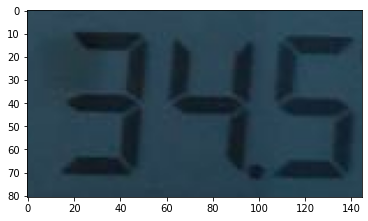

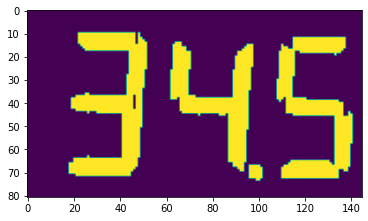

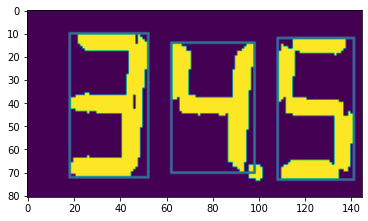

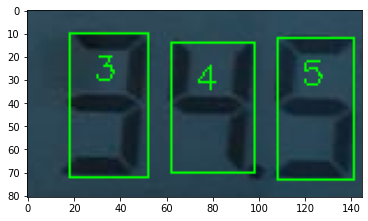

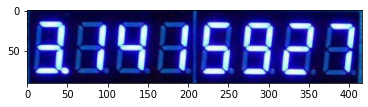

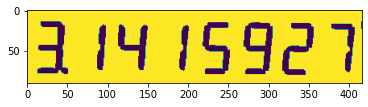

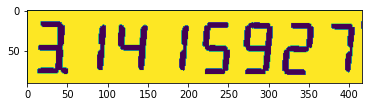

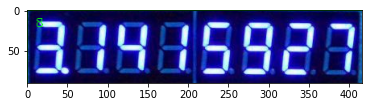

In [68]:
#Executando a base 1 com melhorias (alterando os parametros e operacoes)
def exec_base_1_sem_melh_image_1():
    #Lendo a imagem
    img = cv2.imread("./Base1/unnamed.png")
    show_image(img)
    
    #Limpando a imagem
    #Imagem / valores do kernel / operacoes desejadas
    clean_image = limpa_imagem_oper_morfol(img, (1,5), opn=True, close=True)
    show_image(clean_image)


    #Encontrando os possiveis digitos
    #imagem / largura / altura / largura_min / altura_min (Implementar?)
    img_possiveis_digitos, possiveis_digitos = encontra_digitos_image(clean_image, 10, 3)
    show_image(img_possiveis_digitos)

    #Identificando os possiveis digitos
    #imagem original / imagem limpa / lista de possiveis digitos / area estimada
    res_img, res_digits = classifica_digitos(img, clean_image, possiveis_digitos, 0.5)
    show_image(res_img)
    print(res_digits)
#---------------------

def exec_base_1_sem_melh_image_2():
    #Lendo a imagem
    img = cv2.imread("./Base1/unnamed2.png")
    show_image(img)
    
    #Limpando a imagem
    #Imagem / valores do kernel / operacoes desejadas
    clean_image = limpa_imagem_oper_morfol(img, (1,5), opn=True, close=True)
    show_image(clean_image)


    #Encontrando os possiveis digitos
    #imagem / largura / altura / largura_min / altura_min (Implementar?)
    img_possiveis_digitos, possiveis_digitos = encontra_digitos_image(clean_image, 10, 3)
    show_image(img_possiveis_digitos)

    #Identificando os possiveis digitos
    #imagem original / imagem limpa / lista de possiveis digitos / area estimada
    res_img, res_digits = classifica_digitos(img, clean_image, possiveis_digitos, 0.5)
    show_image(res_img)
    print(res_digits)
#---------------------

def exec_base_1_sem_melh_image_3():
    #Lendo a imagem
    img = cv2.imread("./Base1/unnamed3.png")
    show_image(img)
    
    #Limpando a imagem
    #Imagem / valores do kernel / operacoes desejadas
    clean_image = limpa_imagem_oper_morfol(img, (1,5), opn=True, close=True)
    show_image(clean_image)


    #Encontrando os possiveis digitos
    #imagem / largura / altura / largura_min / altura_min (Implementar?)
    img_possiveis_digitos, possiveis_digitos = encontra_digitos_image(clean_image, 10, 3)
    show_image(img_possiveis_digitos)

    #Identificando os possiveis digitos
    #imagem original / imagem limpa / lista de possiveis digitos / area estimada
    res_img, res_digits = classifica_digitos(img, clean_image, possiveis_digitos, 0.5)
    show_image(res_img)
    print(res_digits)
#---------------------

#lista_imgs = ["./Base1/unnamed.png", "./Base1/unnamed2.png", "./Base1/unnamed3.png"]
def exec_base_1_sem_melhoria():
    exec_base_1_sem_melh_image_1()
    exec_base_1_sem_melh_image_2()
    exec_base_1_sem_melh_image_3()
    
exec_base_1_sem_melhoria()

## -> Apenas a segunda imagem acertou os números, as demais necessitam de melhorias

# Executando a primeira base de testes COM melhorias
## Passando diferentes parâmetros e operações
## Adaptando o código para tais alterações, além do tratamento do número 1

[2, 7, 1, 8]
[3, 4, 5]
[3, 1, 4, 1, 5, 9, 2, 7]


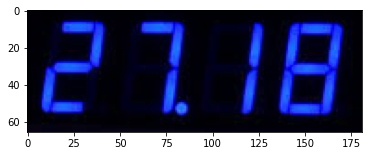

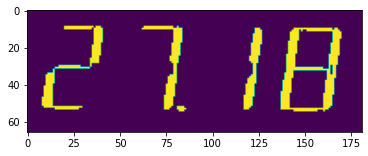

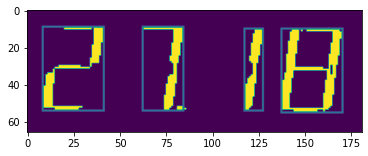

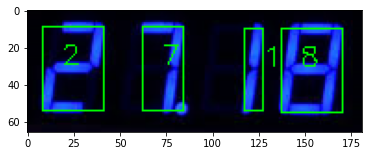

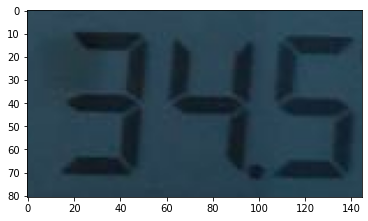

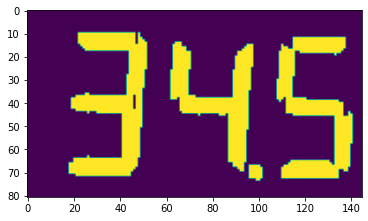

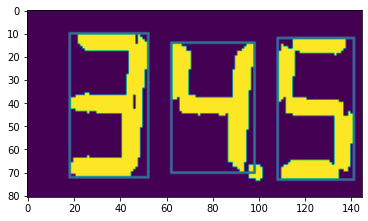

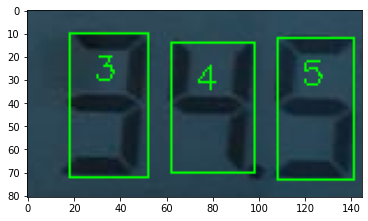

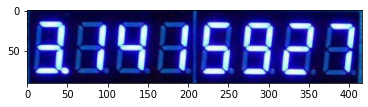

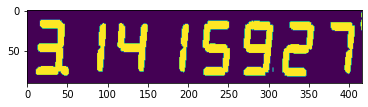

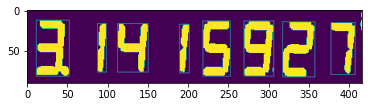

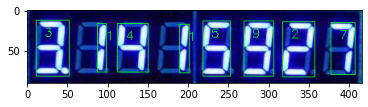

In [69]:
#Executando a base 1 com melhorias (alterando os parametros e operacoes)
def exec_base_1_com_melh_image_1():
    #Lendo a imagem
    img = cv2.imread("./Base1/unnamed.png")
    show_image(img)
    
    #Limpando a imagem
    #Imagem / valores do kernel / operacoes desejadas
    clean_image = limpa_imagem_oper_morfol(img, (1,5), inv_cor=True, eros=True)
    show_image(clean_image)


    #Encontrando os possiveis digitos
    #imagem / largura / altura / largura_min / altura_min (Implementar?)
    img_possiveis_digitos, possiveis_digitos = encontra_digitos_image(clean_image, 10, 10)
    show_image(img_possiveis_digitos)

    #Identificando os possiveis digitos
    #imagem original / imagem limpa / lista de possiveis digitos / area estimada / valores para o numero '1'
    res_img, res_digits = classifica_digitos(img, clean_image, possiveis_digitos, 0.25, width_1=20,height_1=40)
    show_image(res_img)
    print(res_digits)
#---------------------

def exec_base_1_com_melh_image_2():
    #Lendo a imagem
    img = cv2.imread("./Base1/unnamed2.png")
    show_image(img)
    
    #Limpando a imagem
    #Imagem / valores do kernel / operacoes desejadas
    clean_image = limpa_imagem_oper_morfol(img, (1,5), opn=True, close=True)
    show_image(clean_image)


    #Encontrando os possiveis digitos
    #imagem / largura / altura / largura_min / altura_min (Implementar?)
    img_possiveis_digitos, possiveis_digitos = encontra_digitos_image(clean_image, 10, 3)
    show_image(img_possiveis_digitos)

    #Identificando os possiveis digitos
    #imagem original / imagem limpa / lista de possiveis digitos / area estimada
    res_img, res_digits = classifica_digitos(img, clean_image, possiveis_digitos, 0.5)
    show_image(res_img)
    print(res_digits)
#---------------------

def exec_base_1_com_melh_image_3():
    #Lendo a imagem
    img = cv2.imread("./Base1/unnamed3.png")
    show_image(img)
    
    #Limpando a imagem
    #Imagem / valores do kernel / operacoes desejadas
    clean_image = limpa_imagem_oper_morfol(img, (1,5), inv_cor=True, dilat=True)
    show_image(clean_image)


    #Encontrando os possiveis digitos
    #imagem / largura / altura / largura_min / altura_min (Implementar?)
    img_possiveis_digitos, possiveis_digitos = encontra_digitos_image(clean_image, 10, 10)
    show_image(img_possiveis_digitos)

    #Identificando os possiveis digitos
    #imagem original / imagem limpa / lista de possiveis digitos / area estimada / valores para o numero '1'
    res_img, res_digits = classifica_digitos(img, clean_image, possiveis_digitos, 0.4, width_1=20,height_1=40)
    show_image(res_img)
    print(res_digits)
#---------------------

#lista_imgs = ["./Base1/unnamed.png", "./Base1/unnamed2.png", "./Base1/unnamed3.png"]
def exec_base_1_com_melhorias():
    exec_base_1_com_melh_image_1()
    exec_base_1_com_melh_image_2()
    exec_base_1_com_melh_image_3()
    
exec_base_1_com_melhorias()

# TESTE DA BASE 2

## Função para recorte da imagem
### Necessário devido ao tamanho de centralização dos dígitos de algumas imagens

In [70]:
def cut_image(img):
    #image = cv2.imread(caminho_imagem)
    image = imutils.resize(img, height=500)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(blurred, 50, 200, 255)
    
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        
        if(len(approx) == 4):
            displayCnt = approx
            break
    warped = four_point_transform(gray, displayCnt.reshape(4, 2))
    output = four_point_transform(image, displayCnt.reshape(4, 2))
    
    return edged, output

## Execução da segunda base de testes

['NF', 8, 'NF']


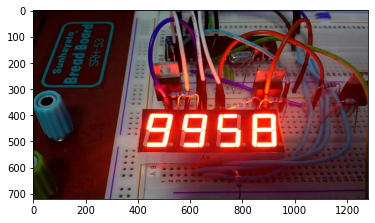

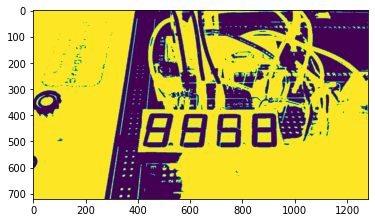

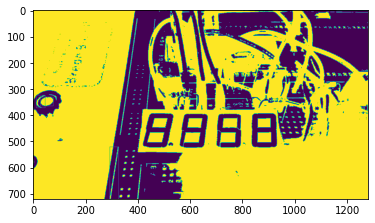

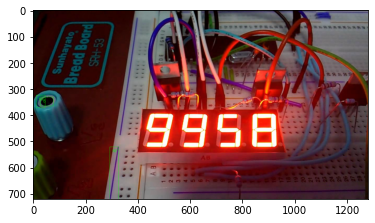

In [124]:
#OK!
def exec_base_2_image_5():
    imagem_teste = "./Base2/ex5.png"

    #Lendo a imagem
    img = cv2.imread(imagem_teste)
    show_image(img)

    #Limpando a imagem
    clean_image = limpa_imagem_oper_morfol(img, (5,5),inv_cor=True, dilat=True)
    show_image(clean_image)

    #Encontrando os possiveis digitos
    img_possiveis_digitos, possiveis_digitos = encontra_digitos_image(clean_image, 30, 30)
    show_image(img_possiveis_digitos)

    #Identificando os possiveis digitos
    res_img, res_digits = classifica_digitos(img, clean_image, possiveis_digitos, 0.5)
    show_image(res_img)
    print(res_digits)
#---------------------

#OK!
def exec_base_2_image_6():
    imagem_teste = "./Base2/ex6.jpg"

    #Lendo a imagem
    img = cv2.imread(imagem_teste)
    show_image(img)

    
    #Cortando a imagem
    img_bordas, imagem_cortada = cut_image(img)
    show_image(img_bordas)
    show_image(imagem_cortada)
    
    #Limpando a imagem
    clean_image = limpa_imagem_oper_morfol(imagem_cortada, (1,5), opn=True, close=True)
    #clean_image = limpa_imagem_oper_morfol(imagem_cortada, (1,3), dilat=True)
    show_image(clean_image)

    #Encontrando os possiveis digitos
    #Aqui eh necessario passar os valores de max_width e max_height, devido a retangulos irregulares encontrados
    img_possiveis_digitos, possiveis_digitos = encontra_digitos_image(clean_image,10,20,max_width=40,max_height=40)
    show_image(img_possiveis_digitos)

    #Identificando os possiveis digitos
    res_img, res_digits = classifica_digitos(imagem_cortada, clean_image, possiveis_digitos, 0.5)
    show_image(res_img)
    print(res_digits)
#---------------------

###INCOMPLETO!!!
def exec_base_2_image_9():
    imagem_teste = "./Base2/ex9.jpg"

    #Lendo a imagem
    img = cv2.imread(imagem_teste)
    show_image(img)

    #Limpando a imagem
    clean_image = limpa_imagem_oper_morfol(img, (5,5),inv_cor=True, eros=True, opn=False, dilat=True, close=True)
    show_image(clean_image)

    #Encontrando os possiveis digitos
    img_possiveis_digitos, possiveis_digitos = encontra_digitos_image(clean_image, 30, 30, max_width=80)
    show_image(img_possiveis_digitos)

    #Identificando os possiveis digitos
    res_img, res_digits = classifica_digitos(img, clean_image, possiveis_digitos, 0.5)
    show_image(res_img)
    print(res_digits)
#---------------------

###INCOMPLETO!!!
def exec_base_2_image_8():
    imagem_teste = "./Base2/ex8.jpg"

    #Lendo a imagem
    img = cv2.imread(imagem_teste)
    show_image(img)

    #Limpando a imagem
    clean_image = limpa_imagem_oper_morfol(img, (5,5),inv_cor=False)
    show_image(clean_image)

    #Encontrando os possiveis digitos
    img_possiveis_digitos, possiveis_digitos = encontra_digitos_image(clean_image, 30, 30, max_width=80)
    show_image(img_possiveis_digitos)

    #Identificando os possiveis digitos
    res_img, res_digits = classifica_digitos(img, clean_image, possiveis_digitos, 0.5)
    show_image(res_img)
    print(res_digits)
#---------------------

###INCOMPLETO!!!
def exec_base_2_image_7():
    imagem_teste = "./Base2/ex7.jpg"

    #Lendo a imagem
    img = cv2.imread(imagem_teste)
    show_image(img)

    #Limpando a imagem
    clean_image = limpa_imagem_oper_morfol(img, (5,5),inv_cor=True)
    show_image(clean_image)

    #Encontrando os possiveis digitos
    img_possiveis_digitos, possiveis_digitos = encontra_digitos_image(clean_image, 30, 30, max_width=80)
    show_image(img_possiveis_digitos)

    #Identificando os possiveis digitos
    res_img, res_digits = classifica_digitos(img, clean_image, possiveis_digitos, 0.5)
    show_image(res_img)
    print(res_digits)
#---------------------

def exec_base_2_image_11():
    imagem_teste = "./Base2/ex11.jpg"

    #Lendo a imagem
    img = cv2.imread(imagem_teste)
    show_image(img)

    #Limpando a imagem
    clean_image = limpa_imagem_oper_morfol(img, (1,5),inv_cor=False, eros=False, dilat=False)
    show_image(clean_image)

    #Encontrando os possiveis digitos
    img_possiveis_digitos, possiveis_digitos = encontra_digitos_image(clean_image, 30, 30, max_width=50)
    show_image(img_possiveis_digitos)

    #Identificando os possiveis digitos
    res_img, res_digits = classifica_digitos(img, clean_image, possiveis_digitos, 0.4)
    show_image(res_img)
    print(res_digits)
#---------------------

#OK!
def exec_base_2_image_12():
    imagem_teste = "./Base2/ex12.jpg"

    #Lendo a imagem
    img = cv2.imread(imagem_teste)
    show_image(img)

    #Limpando a imagem
    clean_image = limpa_imagem_oper_morfol(img, (5,5),inv_cor=True, eros=True, dilat=True)
    show_image(clean_image)

    #Encontrando os possiveis digitos
    img_possiveis_digitos, possiveis_digitos = encontra_digitos_image(clean_image, 30, 30, max_width=50)
    show_image(img_possiveis_digitos)

    #Identificando os possiveis digitos
    res_img, res_digits = classifica_digitos(img, clean_image, possiveis_digitos, 0.4)
    show_image(res_img)
    print(res_digits)
#---------------------



'''
lista_imgs = ["./Base2/ex4.png", "./Base2/ex5.png", "./Base2/ex6.png", "./Base2/ex7.jpg", "./Base2/ex8.jpg", 
               "./Base2/ex9.jpg", "./Base2/ex10.jpg", "./Base2/ex11.jpg", "./Base2/ex12.jpg"]    
'''
def exec_base2():
    #exec_base_2_image_4()
    #exec_base_2_image_5() #OK!
    #exec_base_2_image_6() #OK!
    #exec_base_2_image_7()
    #exec_base_2_image_8()
    #exec_base_2_image_9()
    #exec_base_2_image_10()
    exec_base_2_image_11()
    #exec_base_2_image_12() #OK!

exec_base2()